In [27]:
import requests
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime

pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 10)

In [28]:
FRED_API_KEY = "a8837523b7c200b627e6e1f1a7275566"
SERIES_ID = "DGS1"
START_DATE = "2020-01-01"
END_DATE   = "2025-12-31"

def fetch_fred_series(series_id, start_date, end_date, api_key):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        "observation_start": start_date,
        "observation_end": end_date,
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()
    
    obs = data["observations"]
    dates = [o["date"] for o in obs]
    values = []
    for o in obs:
        v = o["value"]
        # FRED uses "." to denote missing values
        if v == ".":
            values.append(np.nan)
        else:
            values.append(float(v))
    
    df = pd.DataFrame({"date": pd.to_datetime(dates), "rate_pct": values})
    df.set_index("date", inplace=True)
    return df

rates_raw = fetch_fred_series(SERIES_ID, START_DATE, END_DATE, FRED_API_KEY)

rates_raw.head(), rates_raw.tail()


(            rate_pct
 date                
 2020-01-01       NaN
 2020-01-02      1.56
 2020-01-03      1.55
 2020-01-06      1.54
 2020-01-07      1.53,
             rate_pct
 date                
 2025-11-28      3.61
 2025-12-01      3.62
 2025-12-02      3.59
 2025-12-03      3.57
 2025-12-04      3.60)

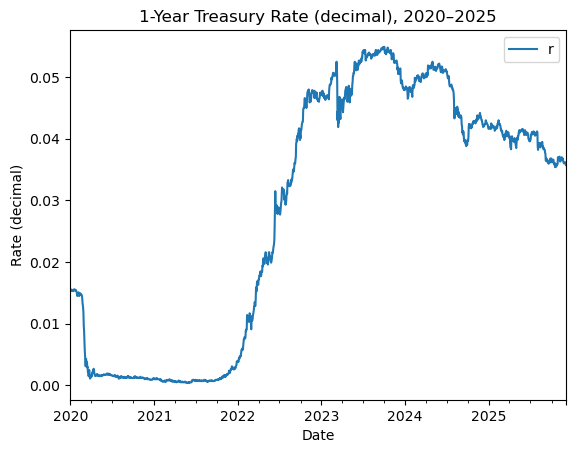

,r
date,
2020-01-01,0.0156
2020-01-02,0.0156
2020-01-03,0.0155
2020-01-06,0.0154
2020-01-07,0.0153


In [29]:
rates = rates_raw.copy()
rates["rate_pct"] = rates["rate_pct"].astype(float)
rates["rate_pct"] = rates["rate_pct"].interpolate(limit_direction="both")


rates["r"] = rates["rate_pct"] / 100.0


rates = rates[["r"]]

rates.plot(title="1-Year Treasury Rate (decimal), 2020–2025")
plt.xlabel("Date")
plt.ylabel("Rate (decimal)")
plt.show()

rates.head()

In [30]:
r_series = rates["r"].dropna()
r_t   = r_series.shift(1).dropna()
r_tp1 = r_series.loc[r_t.index]

df_reg = pd.DataFrame({"r_t": r_t, "r_tp1": r_tp1}).dropna()


delta = 1.0 / 252.0

X = sm.add_constant(df_reg["r_t"])
y = df_reg["r_tp1"]

model = sm.OLS(y, X).fit()
alpha = model.params["const"]
beta  = model.params["r_t"]
s2    = model.mse_resid

alpha, beta, s2, model.rsquared

(np.float64(2.3128049629683914e-05),
 np.float64(0.9996474767711435),
 np.float64(2.423463158481906e-07),
 np.float64(0.9994403662831522))

In [31]:
phi = beta
if not (0 < phi < 1):
    print("Warning: phi is not in (0,1); Vasicek interpretation may be problematic.")

b = alpha / (1 - phi)
a = -np.log(phi) / delta
sigma2 = s2 * 2 * a / ((1 - phi**2) * delta)
sigma = np.sqrt(sigma2)

print("Estimated Vasicek parameters:")
print(f"a (speed of mean reversion): {a:.4f}")
print(f"b (long-run mean)         : {b:.4%} (decimal)")
print(f"sigma (vol of short rate) : {sigma:.4%} (per sqrt(year))")
print(f"AR(1) R^2                 : {model.rsquared:.4f}")

Estimated Vasicek parameters:
a (speed of mean reversion): 0.0889
b (long-run mean)         : 6.5607% (decimal)
sigma (vol of short rate) : 12.4078% (per sqrt(year))
AR(1) R^2                 : 0.9994


In [32]:
r0 = r_series.iloc[-1]
T_horizon = 1.0

m_T = b + (r0 - b) * np.exp(-a * T_horizon)
v_T = sigma**2 / (2 * a) * (1 - np.exp(-2 * a * T_horizon))
std_T = np.sqrt(v_T)

print(f"Last observed r_0 (end of 2025): {r0:.4%}")
print(f"Mean of r_T (end of 2026)     : {m_T:.4%}")
print(f"Std dev of r_T                : {std_T:.4%}")

Last observed r_0 (end of 2025): 3.6000%
Mean of r_T (end of 2026)     : 3.8517%
Std dev of r_T                : 11.8765%


In [33]:
n_sims = 100_000
rng = np.random.default_rng(seed=42)
r_T_samples = rng.normal(loc=m_T, scale=std_T, size=n_sims)

quantiles = np.quantile(r_T_samples, [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
quantiles_series = pd.Series(
    quantiles,
    index=["1%", "5%", "25%", "50%", "75%", "95%", "99%"]
)

print("Predictive distribution for r_T (end of 2026), in %:")
print((quantiles_series * 100).round(3))

Predictive distribution for r_T (end of 2026), in %:
1%    -23.981
5%    -15.844
25%    -4.207
50%     3.745
75%    11.805
95%    23.406
99%    31.681
dtype: float64


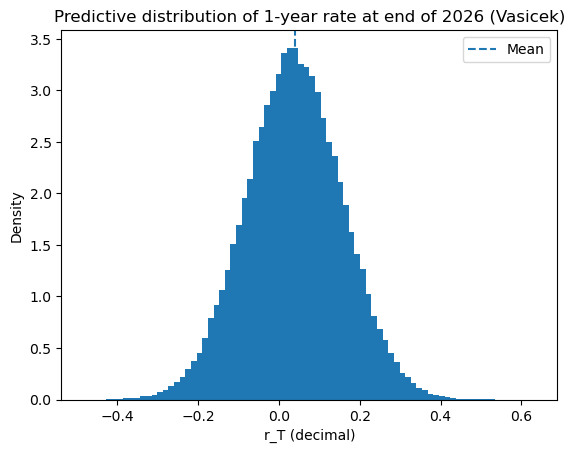

In [34]:
plt.hist(r_T_samples, bins=80, density=True)
plt.axvline(m_T, linestyle="--", label="Mean")
plt.title("Predictive distribution of 1-year rate at end of 2026 (Vasicek)")
plt.xlabel("r_T (decimal)")
plt.ylabel("Density")
plt.legend()
plt.show()

In [35]:
def simulate_vasicek_paths(r0, a, b, sigma, T, n_steps, n_paths, seed=123):
    dt = T / n_steps
    rng = np.random.default_rng(seed=seed)
    r_paths = np.zeros((n_steps + 1, n_paths))
    r_paths[0, :] = r0
    
    for t in range(1, n_steps + 1):
        z = rng.standard_normal(size=n_paths)
        r_prev = r_paths[t - 1, :]
        # Euler step
        dr = a * (b - r_prev) * dt + sigma * np.sqrt(dt) * z
        r_paths[t, :] = r_prev + dr
    
    return r_paths


n_steps_2026 = 252
n_paths_2026 = 20_000

r_paths_2026 = simulate_vasicek_paths(
    r0=r0, a=a, b=b, sigma=sigma, 
    T=1.0, n_steps=n_steps_2026, n_paths=n_paths_2026, seed=123
)

r_paths_2026.shape

(253, 20000)

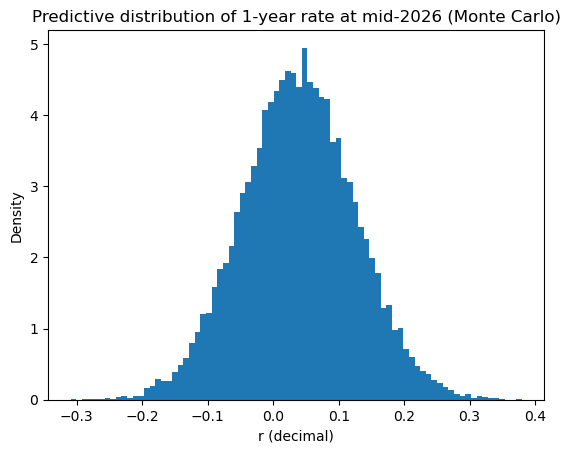

5%    -10.343473
50%     3.848220
95%    18.099723
dtype: float64

In [36]:
mid_index = n_steps_2026 // 2
mid_samples = r_paths_2026[mid_index, :]

plt.hist(mid_samples, bins=80, density=True)
plt.title("Predictive distribution of 1-year rate at mid-2026 (Monte Carlo)")
plt.xlabel("r (decimal)")
plt.ylabel("Density")
plt.show()

pd.Series(np.quantile(mid_samples, [0.05, 0.5, 0.95]), index=["5%", "50%", "95%"]) * 100

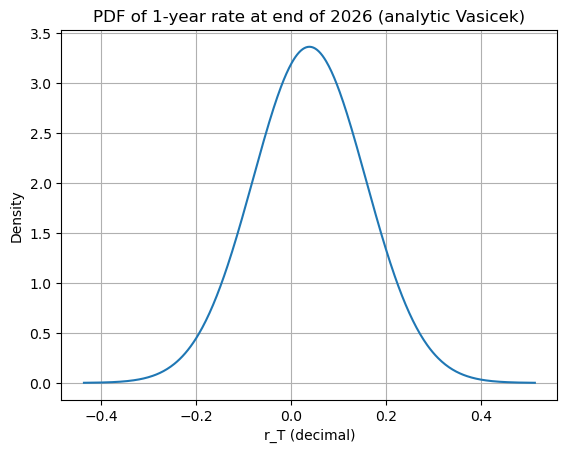

In [37]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

x_grid = np.linspace(m_T - 4*std_T, m_T + 4*std_T, 500)

pdf_grid = norm.pdf(x_grid, loc=m_T, scale=std_T)

plt.plot(x_grid, pdf_grid)
plt.title("PDF of 1-year rate at end of 2026 (analytic Vasicek)")
plt.xlabel("r_T (decimal)")
plt.ylabel("Density")
plt.grid(True)
plt.show()

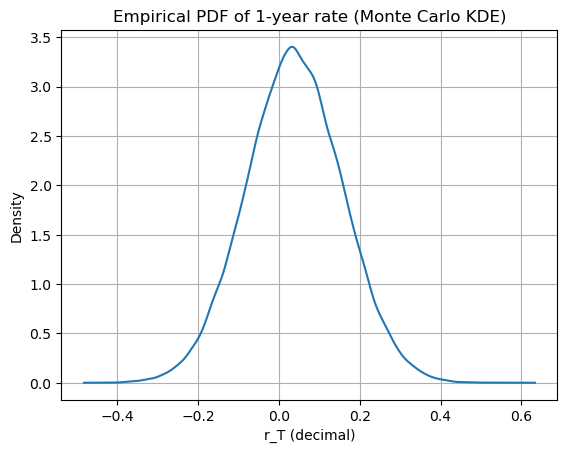

In [38]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

kde = gaussian_kde(r_T_samples)

x_grid_emp = np.linspace(min(r_T_samples), max(r_T_samples), 500)
pdf_emp = kde(x_grid_emp)

plt.plot(x_grid_emp, pdf_emp)
plt.title("Empirical PDF of 1-year rate (Monte Carlo KDE)")
plt.xlabel("r_T (decimal)")
plt.ylabel("Density")
plt.grid(True)
plt.show()